In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

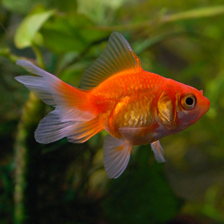

In [4]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [5]:
gold_fish = np.array(gold_fish)/255
gold_fish.shape

(224, 224, 3)

In [6]:
gold_fish[np.newaxis,...].shape

(1, 224, 224, 3)

In [7]:
result = classifier.predict(gold_fish[np.newaxis,...])
result.shape

(1, 1001)

In [8]:
result

array([[ 0.22101447,  2.0474932 ,  9.622569  , ..., -1.462156  ,
        -0.2814662 , -0.25984958]], dtype=float32)

In [9]:
predict_label_index = np.argmax(result)
predict_label_index

2

In [10]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [11]:
image_labels[predict_label_index]

'goldfish'

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [13]:
data_dir

'.\\datasets\\flower_photos'

In [14]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [15]:
list(data_dir.glob("*/*.jpg"))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [16]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

In [17]:
roses = list(data_dir.glob("roses/*"))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

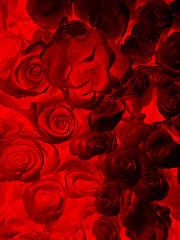

In [18]:
Image.open(str(roses[4]))

In [19]:


flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [20]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 179, 3)

In [21]:
cv2.resize(img, IMAGE_SHAPE).shape

(224, 224, 3)

In [22]:
x, y = [], []
for flower_name, pathlist in flowers_images_dict.items():
    for path in pathlist:
        img = cv2.imread(str(path))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
        

In [23]:
x = np.array(x)
y = np.array(y)

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [25]:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

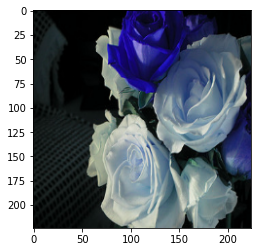

In [26]:
plt.imshow(x[1])

In [27]:
predicted = classifier.predict(np.array([x[0], x[1], x[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 880, 795], dtype=int64)

In [28]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [29]:
num_of_flowers = 5

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(x_train_scaled, y_train, epochs=5)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]